In [1]:
# 基础工具
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context="notebook", style="whitegrid", palette=sns.color_palette("RdBu", 2))

# 使用的模型
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier as XGBC

# 辅助模块
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import KFold
from sklearn.model_selection import learning_curve

#评估指标
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

### 数据预处理

In [2]:
data = pd.read_csv('train.csv')
data.dropna(axis=0,inplace=True)
data.index = range(data.shape[0])
x = data.iloc[:,1:-1]
y = np.array(data.iloc[:,-1:]).ravel()
test = pd.read_csv('test2.csv')
test.drop(['id_num','is_pass',],axis=1,inplace=True)
test = test.fillna(test.median()) #主要是为了填充age

In [3]:
# 众数填充

# imp_mode = SimpleImputer(strategy = "most_frequent")
# x.loc[:,"program_type"] = imp_mode.fit_transform(x.loc[:,"program_type"].values.reshape(-1,1))
# x.loc[:,"difficulty_level"] = imp_mode.fit_transform(x.loc[:,"difficulty_level"].values.reshape(-1,1))
# x.loc[:,"gender"] = imp_mode.fit_transform(x.loc[:,"gender"].values.reshape(-1,1))
# x.loc[:,"education"] = imp_mode.fit_transform(x.loc[:,"education"].values.reshape(-1,1))
# x.loc[:,"is_handicapped"] = imp_mode.fit_transform(x.loc[:,"is_handicapped"].values.reshape(-1,1))
# x.loc[:,"test_type"] = imp_mode.fit_transform(x.loc[:,"test_type"].values.reshape(-1,1))
# x.loc[:,"program_id"] = imp_mode.fit_transform(x.loc[:,"program_id"].values.reshape(-1,1))

In [4]:
# 保护原数据，并进行硬编码
newdata = x
newtest = test

# 硬编码
newdata.iloc[:] = OrdinalEncoder().fit_transform(newdata.iloc[:])
newtest.iloc[:] = OrdinalEncoder().fit_transform(newtest.iloc[:])

### 调参准备

In [5]:
## 学习曲线
def plot_learning_curve(estimator,title, X, y,
                        cv=None, #交叉验证
                        ):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y,
                                                            shuffle=True,
                                                            cv=cv,
                                                            random_state=420
                                                            )
    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.set_xlabel("Training examples")
    ax.set_ylabel("Score")
    ax.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color="r",label="Training score")
    ax.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', color="g",label="Test score")
    ax.legend(loc="best")
    return ax

In [6]:
# 设置五折交叉验证
cv = KFold(n_splits=5, shuffle = True, random_state=42)

### 随机森林

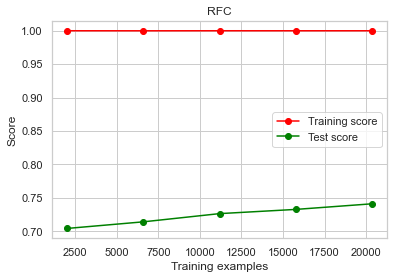

In [7]:
# 先对随机森林进行实例化并绘制不进行特征选择的学习曲线
rfc = RandomForestClassifier(random_state=0)
plot_learning_curve(rfc,"RFC",newdata,y,cv=cv)
plt.show()

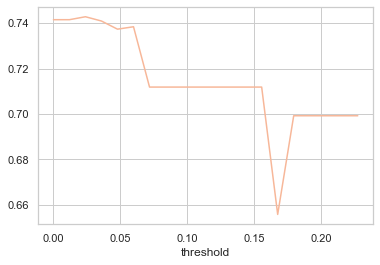

最大准确率为： 0.7427927590381525 对应阈值为： 0.02396455287949477


In [8]:
# 运用学习曲线寻找最优的阈值
threshold = np.linspace(0,(rfc.fit(newdata,y).feature_importances_).max()-0.01,20)
score = []
for i in threshold:
    X_embedded = SelectFromModel(rfc,threshold=i).fit_transform(newdata,y)
    score.append(cross_val_score(rfc,X_embedded,y,cv=5).mean())
fig, ax = plt.subplots()
ax.plot(threshold,score)
ax.set_xlabel('threshold')
plt.show()
print('最大准确率为：',max(score),'对应阈值为：',threshold[score.index(max(score))])

In [9]:
# 进行特征选择，检查去除的特征
sfm = SelectFromModel(rfc, threshold=threshold[score.index(max(score))]).fit(newdata,y)
X_embedded = sfm.transform(newdata)
newdata.columns[~sfm.get_support()]

Index(['program_type', 'is_handicapped'], dtype='object')

In [10]:
# 跑一次随机森林进行分析
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X_embedded,y,test_size=0.3)
rfc = RandomForestClassifier(random_state=0)
rfc = rfc.fit(Xtrain,Ytrain)   #是为了在下一步能传参
score_t = cross_val_score(rfc,X_embedded,y,cv=cv).mean()
print('随机森林准确率为：',score_t)

随机森林准确率为： 0.738506297387975


In [11]:
# 查看特征重要性
feature = pd.Series(newdata.columns[sfm.get_support()])
percent = pd.Series(rfc.feature_importances_)
importance = pd.concat([feature,percent],axis=1,keys=['feature','importance']).sort_values('importance',ascending=False)
importance.set_index('feature')

,importance
feature,
trainee_id,0.244402
test_id,0.176002
age,0.169955
trainee_engagement_rating,0.069468
city_tier,0.064320
total_programs_enrolled,0.061996
program_id,0.048440
education,0.047956
program_duration,0.032993


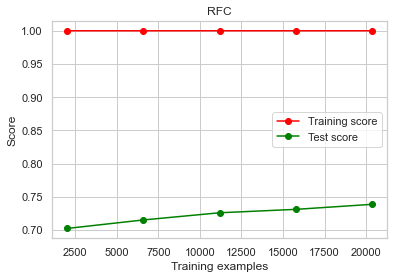

In [12]:
# 对进行特征选择之后的数据绘制学习曲线
plot_learning_curve(rfc,"RFC",X_embedded,y,cv=cv)
plt.show()

### 梯度提升树

In [13]:
# 实例化
xgbc = XGBC(random_state=410,use_label_encoder=False,eval_metric='logloss')

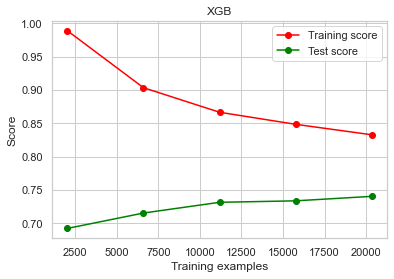

In [14]:
# 不进行特征选择下的学习曲线
plot_learning_curve(xgbc,"XGB",newdata,y,cv=cv)
plt.show()

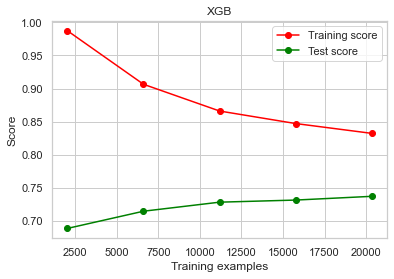

In [15]:
# 进行特征选择后的学习曲线
plot_learning_curve(xgbc,"XGB",X_embedded,y,cv=cv)
plt.show()

### 模型优化

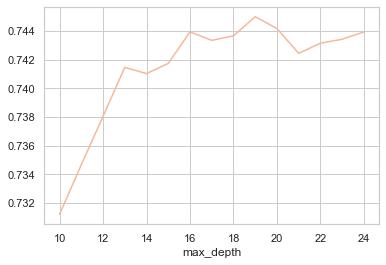

最大准确率为： 0.7449955184671023 对应深度为： 19


In [16]:
# 随机森林优化
score=[]
max_depth = range(10,25)
for i in max_depth:
    rfc = RandomForestClassifier(max_depth=i,random_state=0)
    score.append(cross_val_score(rfc,X_embedded,y,cv=10).mean())
fig, ax = plt.subplots()
ax.plot(max_depth,score)
ax.set_xlabel('max_depth')
plt.show()
print('最大准确率为：',max(score),'对应深度为：',max_depth[score.index(max(score))])

In [17]:
# 调参后模型
rfc = RandomForestClassifier(max_depth=19,random_state=0)
score_t = cross_val_score(rfc,X_embedded,y,cv=10).mean()
print('随机森林准确率为：',score_t)

随机森林准确率为： 0.7449955184671023


偏差最低时对应的参数为： 350 此时准确率为： 0.7456640493443935 此时方差为: 1.598724221604885e-05
方差差最低时对应的参数为： 150 此时准确率为： 0.7399222575245599 此时方差为: 1.0847454871420201e-05
最低泛化误差对应参数为： 350 此时准确率为： 0.7456640493443935 此时方差为： 1.598724221604885e-05


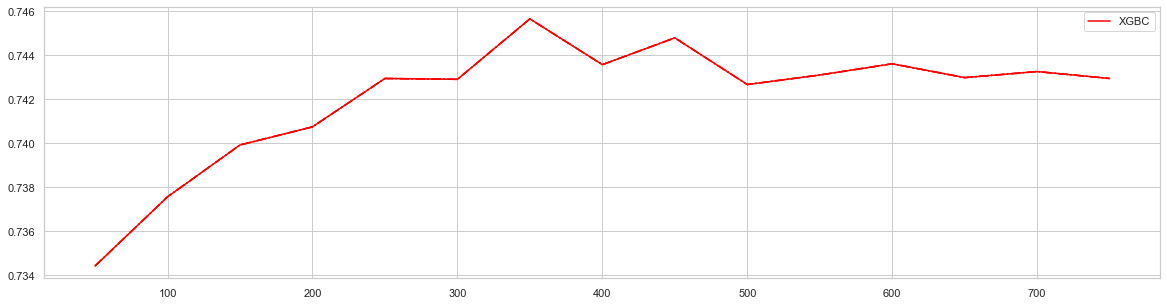

In [18]:
# 梯度提升树优化

value = range(50,800,50)
bias = [] # 偏差记录
variance = [] # 方差记录
score = []
for i in value:
    xgbc = XGBC(n_estimators=i,random_state=50,use_label_encoder=False,eval_metric='logloss')
    cvresult = cross_val_score(xgbc,X_embedded,y,cv=cv)
    # 记录偏差
    bias.append(cvresult.mean())
    # 记录方差
    variance.append(cvresult.var())
    # 计算泛化误差
    score.append((1 - cvresult.mean())**2+cvresult.var())
    
# 打印R2最高所对应的参数取值，并打印这个参数下的方差
print('偏差最低时对应的参数为：',value[bias.index(max(bias))],
      '此时准确率为：',max(bias), 
      '此时方差为:',variance[bias.index(max(bias))])
# 打印方差最低时对应的参数取值，并打印这个参数下的R2
print('方差差最低时对应的参数为：',value[variance.index(min(variance))], 
      '此时准确率为：',bias[variance.index(min(variance))], 
      '此时方差为:',min(variance))
# 打印泛化误差可控部分的参数取值，并打印这个参数下的R2，方差以及泛化误差的可控部分
print('最低泛化误差对应参数为：',value[score.index(min(score))],
      '此时准确率为：',bias[score.index(min(score))],
      '此时方差为：',variance[score.index(min(score))])

rs = np.array(bias)
var = np.array(variance)*0.01
plt.figure(figsize=(20,5))
plt.plot(value,rs,c="red",label="XGBC")
# 添加方差线
plt.plot(value,rs+var,c="red",linestyle='-.')
plt.plot(value,rs-var,c="red",linestyle='-.')
plt.legend()
plt.show()

In [19]:
# 调参后模型
xgbc = XGBC(n_estimators=350,random_state=50,use_label_encoder=False,eval_metric='logloss')
score_t = cross_val_score(xgbc,X_embedded,y,cv=10).mean()
print('梯度提升树准确率为：',score_t)

梯度提升树准确率为： 0.7490855785601733


### 模型评估

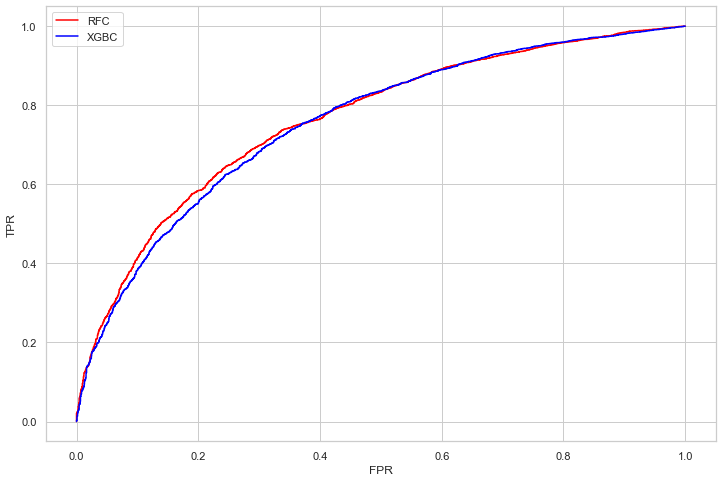

随机森林的AUC分数为： 0.7630521673860011 梯度提升树的AUC分数为： 0.755959189667692


In [20]:
# ROC曲线
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X_embedded,y,test_size=0.3)
rfc.fit(Xtrain,Ytrain)
xgbc.fit(Xtrain,Ytrain)
fpr_rfc, tpr_rfc, thresholds_rfc = roc_curve(Ytest+1, rfc.predict_proba(Xtest)[:,1], pos_label=2)
fpr_xgbc, tpr_xgbc, thresholds_xgbc = roc_curve(Ytest+1, xgbc.predict_proba(Xtest)[:,1], pos_label=2)

# AUC值评估
score_rfc = roc_auc_score(Ytest+1,rfc.predict_proba(Xtest)[:,1])
score_xgbc = roc_auc_score(Ytest+1,xgbc.predict_proba(Xtest)[:,1])

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(fpr_rfc,tpr_rfc,'r',label='RFC')
ax.plot(fpr_xgbc,tpr_xgbc,'b',label='XGBC')
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
ax.legend()
plt.show()
print('随机森林的AUC分数为：',score_rfc,
      '梯度提升树的AUC分数为：',score_xgbc)